In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os
import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'
path_ds='/om2/user/khrovati/data/datasets/d10_1016_j_cell_2020_08_013/'
path_integration=path_data+'/eval/retina_adult_organoid/integration/'
path_save=path_data+'/eval/retina_adult_organoid/integration_summary/'
path_save_mueller=path_save+'mueller_cells/'
path_save_amacrine=path_save+'amacrine_cells/'

In [3]:
# Names
model_map=pkl.load(open(path_names+'models.pkl','rb'))
model_map_rev=dict(zip(model_map.values(),model_map.keys()))
param_map=pkl.load(open(path_names+'params.pkl','rb'))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

In [4]:
# Load embeddings
embeds={}
dataset='retina_adult_organoid'
top_settings=pkl.load(open(f'{path_data}eval/{dataset}/integration_summary/top_settings.pkl','rb'))
path_integration=f'{path_data}eval/{dataset}/integration/'
for model,model_setting in top_settings.items():
    model=model_map[model]
    for run in model_setting['runs']:
        if run==model_setting['mid_run']:
            embeds[model]=sc.read(path_integration+run+'/embed.h5ad')

## Distinct ct locations

Astrocites sem to differ while other cell types are aligned. Same for RPE (also reported in the paper).

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWa

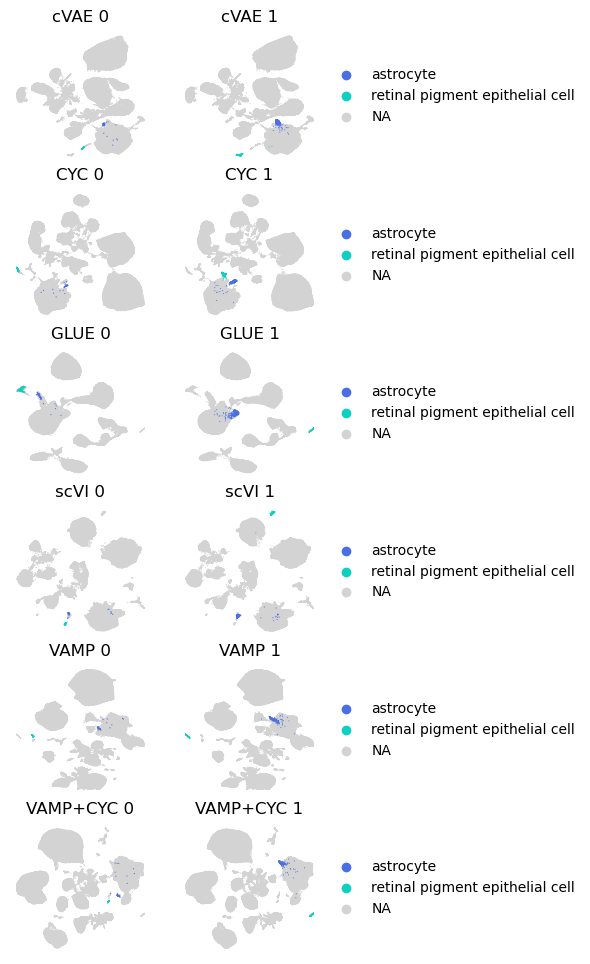

In [24]:
# Astrocytes and retinal pigment epithelial cell
nrow=len(embeds)
ncol=2
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds.items()):
    for j, system in enumerate(sorted(embed.obs.system.unique())):
        ax=axs[i,j]
        sc.pl.umap(embed,ax=ax,show=False,frameon=False)
        sc.pl.umap(embed[embed.obs.system==system,:],color='cell_type',
                   groups=['astrocyte','retinal pigment epithelial cell'],
                   ax=ax,show=False,title=method+' '+system,frameon=False)
        if j==0:
            ax.get_legend().remove()

## Adata for analys of markers

In [12]:
# Load expression for plotting markers
adata={}
for name, fn in [('periphery-adult','periphery'),
                 ('fovea-adult','fovea'),
                 ('organoid','organoid')]:
    a=sc.read(f'{path_ds}{fn}.h5ad')
    a.X=a.raw.X
    adata[name]=a
del a
gc.collect()
adata=sc.concat(adata.values(),
    label='material',keys =adata.keys(),index_unique='-',join='outer',merge='same')
adata=adata[:,
            np.array((adata[adata.obs.material!="organoid",:].X>0).sum(axis=0)>20).ravel()&\
            np.array((adata[adata.obs.material=="organoid",:].X>0).sum(axis=0)>20).ravel()
           ]
adata.obs['system_region']=adata.obs.material.map({
     'periphery-adult':'adult_periphery',
     'fovea-adult':'adult_fovea',
     'organoid':'organoid'})
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
gc.collect()

/tmp/ipykernel_3964173/3709145571.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['system_region']=adata.obs.material.map({


3200

In [26]:
del adata.raw

## Integration of Mueller cells
Check if Mueller cells are more similar to preiphery than fovea, as reported in the paper.

In [27]:
# Subset to mueller cells and recompute embedding
embeds_sub={model:embed[embed.obs.cell_type=="Mueller cell",:].copy() for model,embed in embeds.items()}
for embed in embeds_sub.values():
    print(embed.shape)
    sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
    sc.tl.umap(embed)

Sample metdata UMPAs

In [50]:
# Add organoid age info
org_age=embeds_sub['cVAE'].obs.apply(
    lambda x: x.condition.split('W')[1].split('_')[0] if  x.system=='0' else np.nan,
    axis=1)
for embed in embeds_sub.values():
    embed.obs['org_age']=org_age

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting

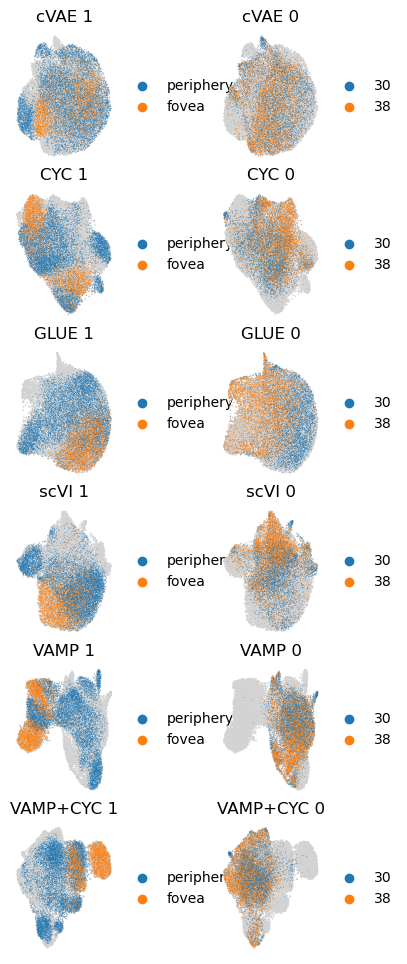

In [53]:
# Sample info on Mueller cells
nrow=len(embeds_sub)
ncol=2
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, system in enumerate(sorted(embed.obs.system.unique())[::-1]):
        ax=axs[i,j]
        sc.pl.umap(embed,ax=ax,show=False,frameon=False)
        if system=='0':
            sc.pl.umap(embed[embed.obs.system==system,:],color='org_age',
                       ax=ax,show=False,title=method+' '+system,frameon=False,s=1)
        else:
            sc.pl.umap(embed[embed.obs.system==system,:],color='region',
                       ax=ax,show=False,title=method+' '+system,frameon=False,s=1)
plt.subplots_adjust(wspace=1)

Periphery/fovea markers

In [54]:
adata_sub=adata[embeds_sub['cVAE'].obs_names,:]

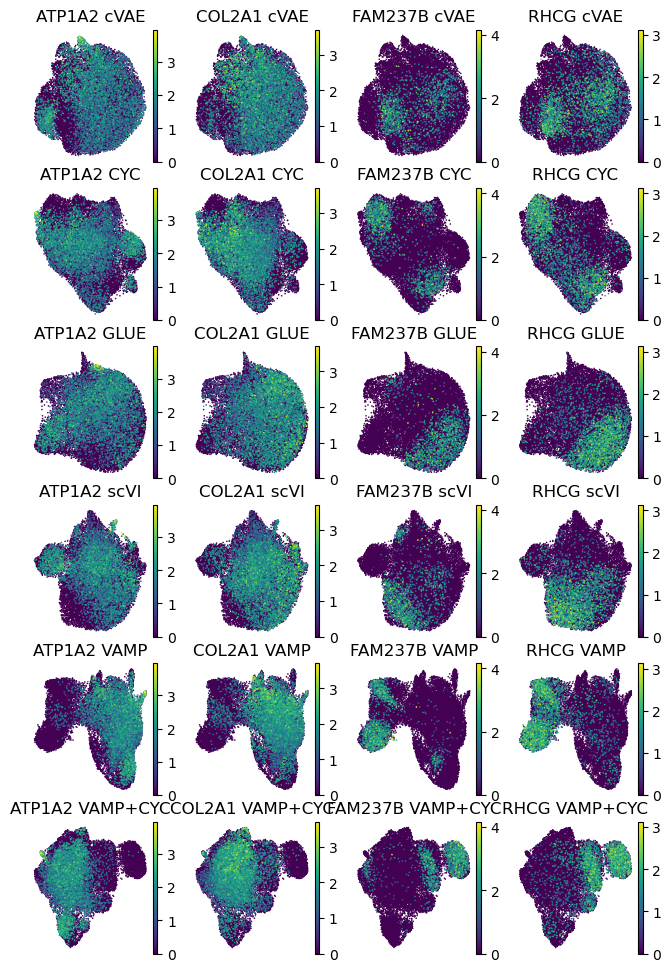

In [55]:
# Expression of periphery/fovea markers
nrow=len(embeds_sub)
genes=['ATP1A2','COL2A1','FAM237B','RHCG']
ncol=len(genes)
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, gene in enumerate(genes):
        ax=axs[i,j]
        adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
        sc.pl.umap(adata_sub,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=gene+ ' '+ method,frameon=False)

Embedding density of organoid/fovea/periphery

In [144]:
# Make categories to analyse (organoid/fovea/periphery)
system_region=embed.obs.apply(
        lambda x: x['material']+('_'+x['region'] if x['material']=='adult' else ''),axis=1)
for embed in embeds_sub.values():
    embed.obs['system_region']=system_region

In [174]:
# Compute density for material (organoid/fovea/periphery)
for embed in embeds_sub.values():
    sc.tl.embedding_density(embed, basis='umap', groupby='system_region')
    embed.uns['umap_density_system_region_params']['covariate']=None

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1520: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[density_col_name] = dens_values
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1520: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[density_col_name] = dens_values
/om2/user/khrovati/miniconda/envs/csi/lib/pyth

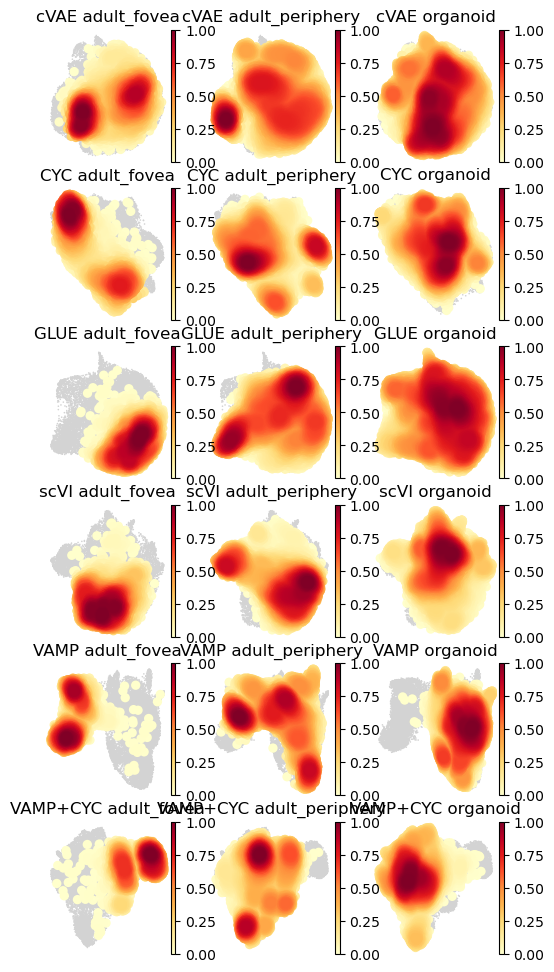

In [179]:
# MEbedding density
nrow=len(embeds_sub)
groups=sorted(system_region.unique())
ncol=len(groups)
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, group in enumerate(groups):
        ax=axs[i,j]
        sc.pl.umap( embed,ax=ax,show=False, frameon=False)
        sc.pl.embedding_density(
            embed[embed.obs.system_region==group,:],
            basis='umap', key='umap_density_system_region', title=method+ ' '+group,
            ax=ax,show=False, frameon=False)

#### Save data for embedding&marker plots

In [24]:
# remove old entries
for embed in embeds_sub.values():
    try:
        for c in ['cell_type_colors', 'leiden',  'sample_id_colors', 'scaled_neighbors', 'system_colors']:
            del embed.uns[c]
        del embed.obsm['X_umap_scaled']
        for c in ['scaled_connectivities', 'scaled_distances']:
            del embed.obsp[c]
    except:
        pass
try:
    del adata.obsm['X_umap']
except:
    pass

In [193]:
# Save embeds with constant model names
embeds_sub={model_map_rev[k]:v for k,v in embeds_sub.items()}

In [195]:
# Save embeds
pkl.dump(embeds_sub,open(path_save_mueller+'density_topmodels.pkl','wb'))

In [34]:
# Reload
# embeds_sub={model_map[k]:v for k,v in 
#             pkl.load(open(path_save_mueller+'density_topmodels.pkl','rb')).items()}

In [29]:
# Save expression
genes=['ATP1A2','COL2A1','FAM237B','RHCG']
adata_sub[:,adata_sub.var.query('feature_name in @genes').index].write(
    path_save_mueller+'adata_markers.h5ad')

## scGEN analysis

Analyse scGEN example with sample-level integration, kl=0.1 and seed=1. Use vamp+cycle for comparison.

In [91]:
embeds_sub1={}
embeds_sub1['vamp_cycle']=embeds[model_map['vamp_cycle']]
example_runs=pkl.load(open(f'{path_data}eval/{dataset}/integration_summary/example_runs.pkl','rb'))
for model,run in example_runs.items():
    embeds_sub1[model]=sc.read(path_integration+run+'/embed.h5ad')                    

### Mueller cells

In [58]:
# Subset to mueller cells and recompute embedding
embeds_sub={model:embed[embed.obs.cell_type=="Mueller cell",:].copy() for model,embed in embeds_sub1.items()}
for embed in embeds_sub.values():
    print(embed.shape)
    sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
    sc.tl.umap(embed)

(22635, 15)


/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/

(22635, 100)
(22635, 100)


In [59]:
# Make categories to analyse (organoid/fovea/periphery)
system_region=embed.obs.apply(
        lambda x: x['material']+('_'+x['region'] if x['material']=='adult' else ''),axis=1)
for embed in embeds_sub.values():
    embed.obs['system_region']=system_region

Markers

In [60]:
adata_sub=adata[embed.obs_names,:]

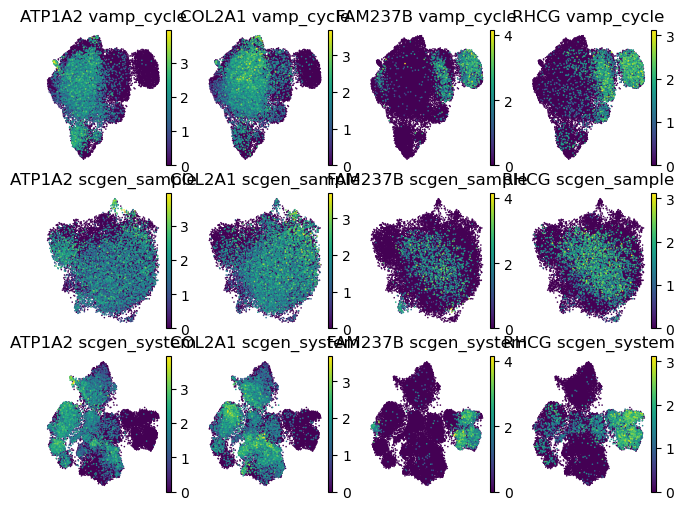

In [68]:
# Expression of periphery/fovea markers, limiting value range
nrow=len(embeds_sub)
genes=['ATP1A2','COL2A1','FAM237B','RHCG']
ncol=len(genes)
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, gene in enumerate(genes):
        ax=axs[i,j]
        adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
        sc.pl.umap(adata_sub,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=gene+ ' '+ method,frameon=False)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


(3886, 22485)
(8207, 22485)
(10542, 22485)
(3886, 22485)
(8207, 22485)
(10542, 22485)
(3886, 22485)
(8207, 22485)
(10542, 22485)


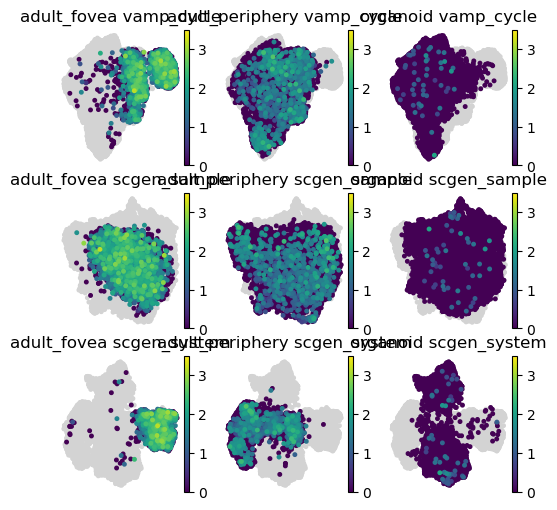

In [70]:
# Expression of periphery/fovea markers
gene='RHCG'
nrow=len(embeds_sub)
ncol=len(embed.obs.system_region.unique())
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
    for j, group in enumerate(sorted(adata.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(adata_sub,ax=ax,show=False,frameon=False,s=50)
        adata_sub_group=adata_sub[adata_sub.obs.system_region==group,:].copy()
        adata_sub_group.obsm['X_umap']=embed[adata_sub_group.obs_names,:].obsm['X_umap']
        print( adata_sub_group.shape)
        sc.pl.umap(adata_sub_group,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=group+ ' '+ method,frameon=False,s=50,sort_order=True,vmax=3.5)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


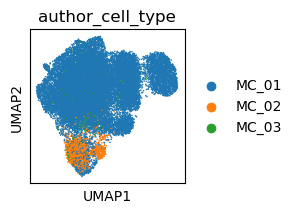

In [72]:
rcParams['figure.figsize']=(2,2)
sc.pl.umap(embeds_sub['vamp_cycle'],color='author_cell_type')

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


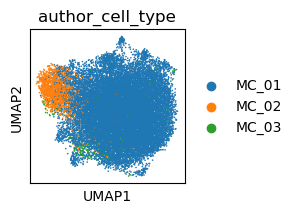

In [73]:
sc.pl.umap(embeds_sub['scgen_sample'],color='author_cell_type')

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


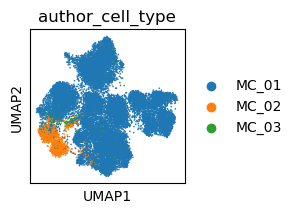

In [74]:
sc.pl.umap(embeds_sub['scgen_system'],color='author_cell_type')

Embedding density

In [66]:
# Compute density for material (organoid/fovea/periphery)
for embed in embeds_sub.values():
    sc.tl.embedding_density(embed, basis='umap', groupby='system_region')
    embed.uns['umap_density_system_region_params']['covariate']=None

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1520: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[density_col_name] = dens_values
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1520: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[density_col_name] = dens_values
/om2/user/khrovati/miniconda/envs/csi/lib/pyth

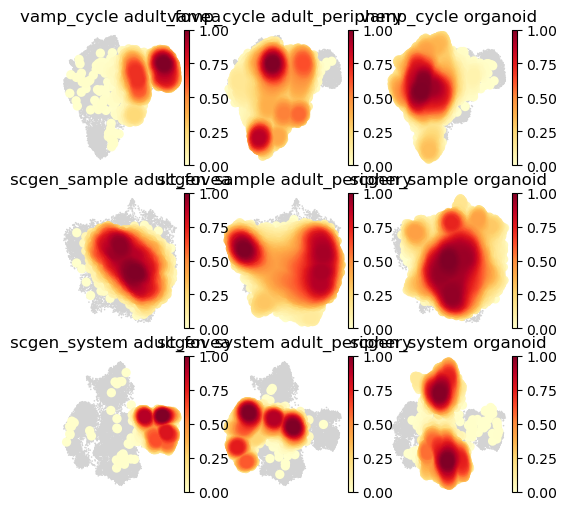

In [67]:
# MEbedding density
nrow=len(embeds_sub)
groups=sorted(system_region.unique())
ncol=len(groups)
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, group in enumerate(groups):
        ax=axs[i,j]
        sc.pl.umap( embed,ax=ax,show=False, frameon=False)
        sc.pl.embedding_density(
            embed[embed.obs.system_region==group,:],
            basis='umap', key='umap_density_system_region', title=method+ ' '+group,
            ax=ax,show=False, frameon=False)

Save

In [174]:
# remove old entries
for embed in embeds_sub:
    try:
        for c in ['cell_type_colors', 'leiden',  'sample_id_colors', 'scaled_neighbors', 'system_colors']:
            del embed.uns[c]
        del embed.obsm['X_umap_scaled']
        for c in ['scaled_connectivities', 'scaled_distances']:
            del embed.obsp[c]
    except:
        pass
try:
    del adata_sub.obsm['X_umap']
except:
    pass

In [175]:
# Save embeds
pkl.dump(
    {'scgen_'+batch:embeds_sub['scgen_'+batch] for batch in ['sample','system']},
     open(path_save_mueller+'density_scgen_example.pkl','wb'))

### Cones

In [75]:
pd.crosstab(
    adata.obs.query('cell_type=="retinal cone cell"')['system_region'],
    adata.obs.query('cell_type=="retinal cone cell"')['author_cell_type'])

author_cell_type  L/M cone  S cone
system_region                     
adult_periphery       1149      53
adult_fovea           1339      36
organoid             12892      81

In [76]:
# Subset to mueller cells and recompute embedding
embeds_sub={model:embed[embed.obs.cell_type=="retinal cone cell",:].copy() for model,embed in embeds_sub1.items()}
for embed in embeds_sub.values():
    print(embed.shape)
    sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
    sc.tl.umap(embed)

(15550, 15)
(15550, 100)
(15550, 100)


In [77]:
# Make categories to analyse (organoid/fovea/periphery)
system_region=embed.obs.apply(
        lambda x: x['material']+('_'+x['region'] if x['material']=='adult' else ''),axis=1)
for embed in embeds_sub.values():
    embed.obs['system_region']=system_region

In [78]:
adata_sub=adata[embed.obs_names,:]

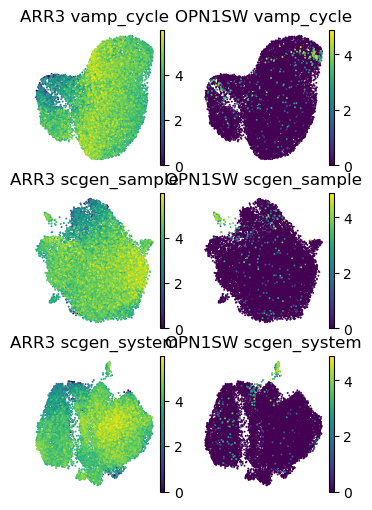

In [79]:
# Expression of periphery/fovea markers
nrow=len(embeds_sub)
genes=['ARR3','OPN1SW']
ncol=len(genes)
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, gene in enumerate(genes):
        ax=axs[i,j]
        adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
        sc.pl.umap(adata_sub,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=gene+ ' '+ method,frameon=False)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


(1375, 22485)
(1202, 22485)
(12973, 22485)
(1375, 22485)
(1202, 22485)
(12973, 22485)
(1375, 22485)
(1202, 22485)
(12973, 22485)


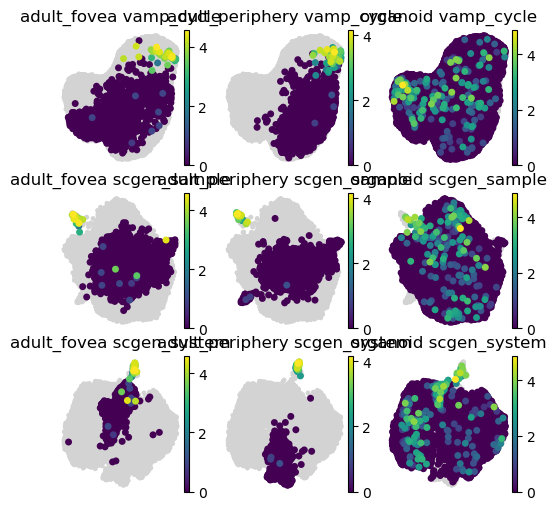

In [80]:
# Expression of periphery/fovea markers
gene='OPN1SW'
nrow=len(embeds_sub)
ncol=len(embed.obs.system_region.unique())
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
    for j, group in enumerate(sorted(adata.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(adata_sub,ax=ax,show=False,frameon=False,s=50)
        adata_sub_group=adata_sub[adata_sub.obs.system_region==group,:].copy()
        adata_sub_group.obsm['X_umap']=embed[adata_sub_group.obs_names,:].obsm['X_umap']
        print( adata_sub_group.shape)
        sc.pl.umap(adata_sub_group,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=group+ ' '+ method,frameon=False,s=100)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


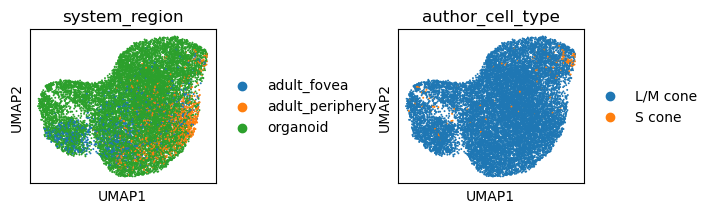

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


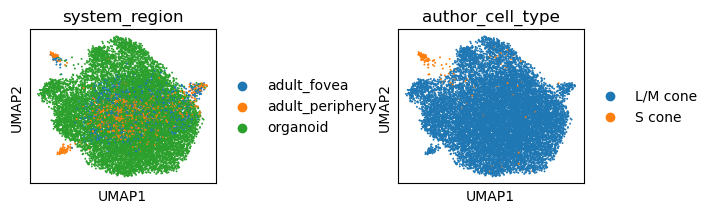

In [44]:
rcParams['figure.figsize']=(2,2)
for i,(method,embed) in enumerate(embeds_sub.items()):
    sc.pl.umap(embed,color=['system_region','author_cell_type'],wspace=0.8)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWa

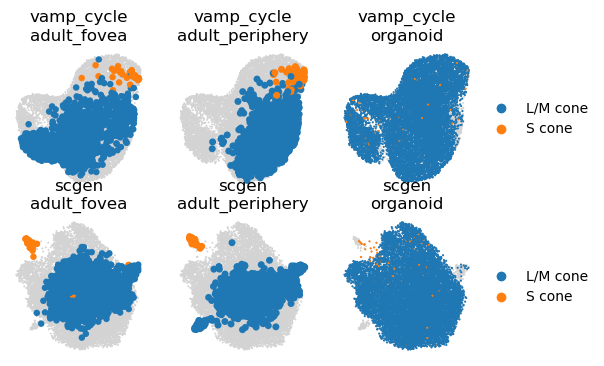

In [57]:
# Astrocytes and retinal pigment epithelial cell
nrow=len(embeds_sub)
ncol=3
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, group in enumerate(sorted(embed.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(embed,ax=ax,show=False,frameon=False)
        sc.pl.umap(embed[embed.obs.system_region==group,:],color='author_cell_type',
                   groups=['L/M cone','S cone'],
                   ax=ax,show=False,title=method+'\n'+group,frameon=False)
        if j<2:
            ax.get_legend().remove()

C: Cone cells are not the best example as they dont have enough cells per ct of interest

### Amarcine
AC_Y_03, AC_B_16

In [176]:
pd.crosstab(
    adata.obs.query('cell_type=="amacrine cell"')['system_region'],
    adata.obs.query('cell_type=="amacrine cell"')['author_cell_type']).T

system_region     fovea-adult  organoid  periphery-adult
author_cell_type                                        
AC_B_01                    29       141               30
AC_B_02                     0        29                0
AC_B_03                     0         0               13
AC_B_04                     0        88                0
AC_B_05                     0        59                0
AC_B_06                     0       167                0
AC_B_07                     0        17               12
AC_B_08                    39        32               40
AC_B_09                     0        13               45
AC_B_10                    16       142               17
AC_B_11                    43        11               12
AC_B_12                     0       253               53
AC_B_13                     0        33                0
AC_B_14                     0         0               14
AC_B_15                    16        51               32
AC_B_16                    17        20               33
AC_B_17                     0       107               17
AC_B_18                    32        67               99
AC_Y_01                     0        58              130
AC_Y_02                     0         0               44
AC_Y_03                   123        23              156

In [81]:
# Subset to mueller cells and recompute embedding
embeds_sub={model:embed[embed.obs.cell_type=="amacrine cell",:].copy() for model,embed in embeds_sub1.items()}
for embed in embeds_sub.values():
    print(embed.shape)
    sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
    sc.tl.umap(embed)

(2373, 15)
(2373, 100)
(2373, 100)


In [82]:
# Make categories to analyse (organoid/fovea/periphery)
system_region=embed.obs.apply(
        lambda x: x['material']+('_'+x['region'] if x['material']=='adult' else ''),axis=1)
for embed in embeds_sub.values():
    embed.obs['system_region']=system_region

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting

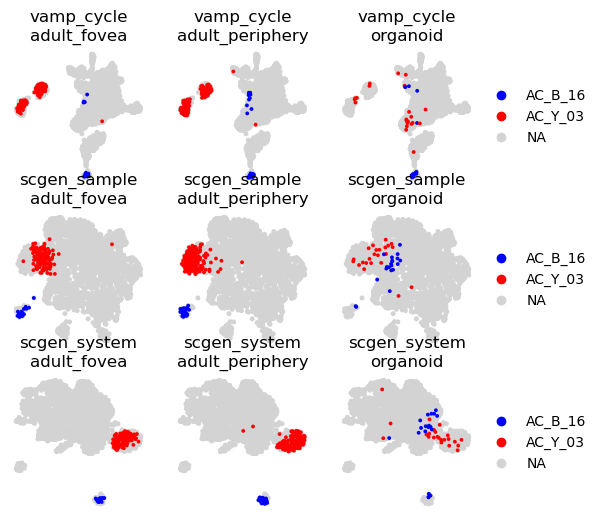

In [180]:
# Astrocytes and retinal pigment epithelial cell
nrow=len(embeds_sub)
ncol=3
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, group in enumerate(sorted(embed.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(embed,ax=ax,show=False,frameon=False)
        sc.pl.umap(embed[embed.obs.system_region==group,:],color='author_cell_type',
                   groups=['AC_Y_03','AC_B_16'],
                   palette={**{ct:'lightgray' for ct in embed.obs.author_cell_type.unique()},
                            **{'AC_Y_03':'r','AC_B_16':'b',}},
                   ax=ax,show=False,title=method+'\n'+group,frameon=False,s=30)
        if j<2:
            ax.get_legend().remove()

In [83]:
adata_sub=adata[embed.obs_names,:]

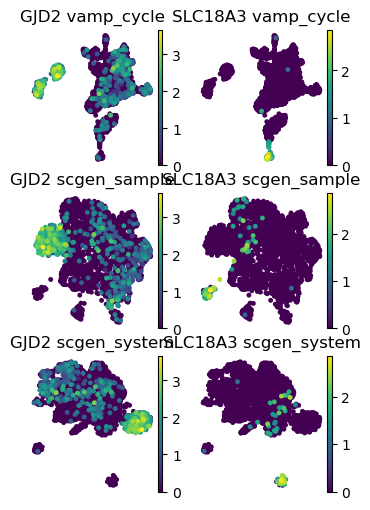

In [84]:
# Expression of periphery/fovea markers
nrow=len(embeds_sub)
genes=['GJD2','SLC18A3']
ncol=len(genes)
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    for j, gene in enumerate(genes):
        ax=axs[i,j]
        adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
        sc.pl.umap(adata_sub,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=gene+ ' '+ method,frameon=False,s=50)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


(315, 22485)
(747, 22485)
(1311, 22485)
(315, 22485)
(747, 22485)
(1311, 22485)
(315, 22485)
(747, 22485)
(1311, 22485)


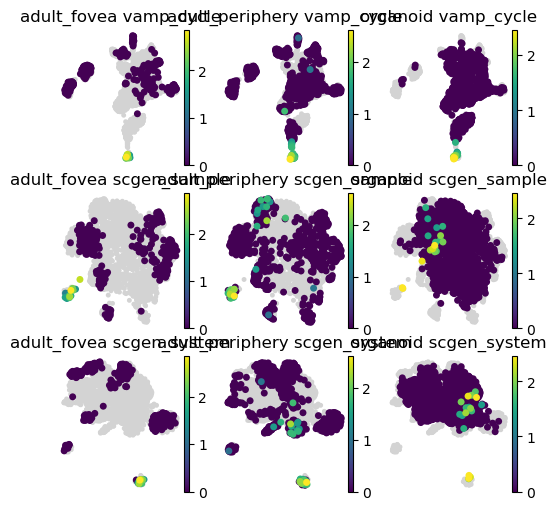

In [85]:
# Expression of periphery/fovea markers
gene='SLC18A3'
nrow=len(embeds_sub)
ncol=len(embed.obs.system_region.unique())
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
    for j, group in enumerate(sorted(adata.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(adata_sub,ax=ax,show=False,frameon=False,s=50)
        adata_sub_group=adata_sub[adata_sub.obs.system_region==group,:].copy()
        adata_sub_group.obsm['X_umap']=embed[adata_sub_group.obs_names,:].obsm['X_umap']
        print( adata_sub_group.shape)
        sc.pl.umap(adata_sub_group,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=group+ ' '+ method,frameon=False,s=100)

(315, 22485)
(747, 22485)
(1311, 22485)
(315, 22485)
(747, 22485)
(1311, 22485)
(315, 22485)
(747, 22485)
(1311, 22485)


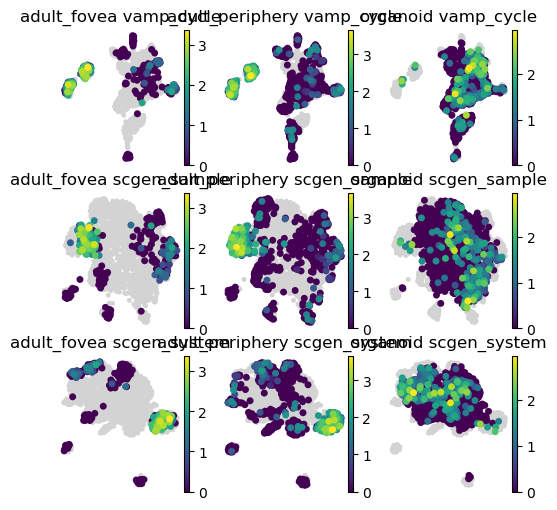

In [86]:
gene='GJD2'
nrow=len(embeds_sub)
ncol=len(embed.obs.system_region.unique())
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
    for j, group in enumerate(sorted(adata.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(adata_sub,ax=ax,show=False,frameon=False,s=50)
        adata_sub_group=adata_sub[adata_sub.obs.system_region==group,:].copy()
        adata_sub_group.obsm['X_umap']=embed[adata_sub_group.obs_names,:].obsm['X_umap']
        print( adata_sub_group.shape)
        sc.pl.umap(adata_sub_group,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=group+ ' '+ method,frameon=False,s=100)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


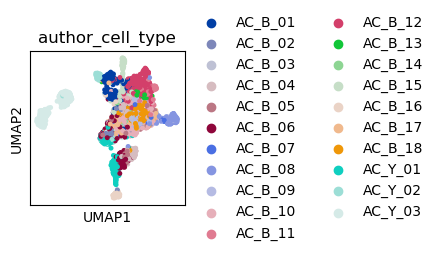

In [185]:
sc.pl.umap(embeds_sub['vamp_cycle'],color='author_cell_type')

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


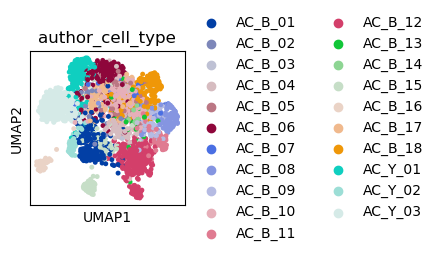

In [187]:
sc.pl.umap(embeds_sub['scgen_sample'],color='author_cell_type')

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


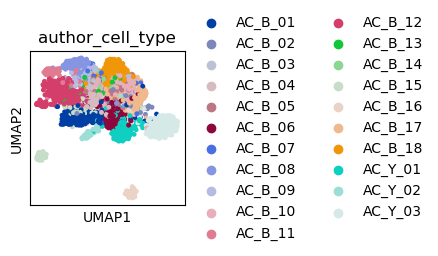

In [188]:
sc.pl.umap(embeds_sub['scgen_system'],color='author_cell_type')

(315, 22485)
(747, 22485)
(1311, 22485)
(315, 22485)
(747, 22485)
(1311, 22485)
(315, 22485)
(747, 22485)
(1311, 22485)


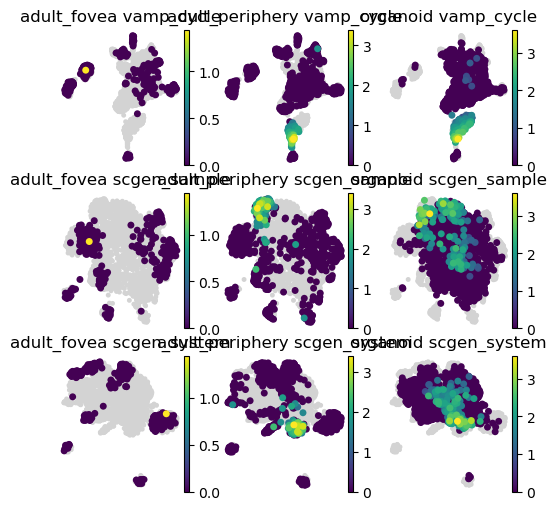

In [87]:
# Expression of periphery/fovea markers
gene='PRDM13'
nrow=len(embeds_sub)
ncol=len(embed.obs.system_region.unique())
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*2, nrow*2))
for i,(method,embed) in enumerate(embeds_sub.items()):
    adata_sub.obsm['X_umap']=embed[adata_sub.obs_names,:].obsm['X_umap']
    for j, group in enumerate(sorted(adata.obs.system_region.unique())):
        ax=axs[i,j]
        sc.pl.umap(adata_sub,ax=ax,show=False,frameon=False,s=50)
        adata_sub_group=adata_sub[adata_sub.obs.system_region==group,:].copy()
        adata_sub_group.obsm['X_umap']=embed[adata_sub_group.obs_names,:].obsm['X_umap']
        print( adata_sub_group.shape)
        sc.pl.umap(adata_sub_group,ax=ax,show=False,color=gene,gene_symbols='feature_name',
                   title=group+ ' '+ method,frameon=False,s=100)

C: It may be better to rely on expression of markers than author annotation as it may be biased & noisy

In [19]:
# remove old entries
for embed in embeds_sub:
    try:
        for c in ['cell_type_colors', 'leiden',  'sample_id_colors', 'scaled_neighbors', 'system_colors']:
            del embed.uns[c]
        del embed.obsm['X_umap_scaled']
        for c in ['scaled_connectivities', 'scaled_distances']:
            del embed.obsp[c]
    except:
        pass
try:
    del adata_sub.obsm['X_umap']
except:
    pass

In [191]:
# Save embeds
pkl.dump(
    {'scgen_'+batch:embeds_sub['scgen_'+batch] for batch in ['sample','system']},
     open(path_save_amacrine+'density_scgen_example.pkl','wb'))

In [192]:
# Save embeds
pkl.dump({'vamp_cycle':embeds_sub['vamp_cycle']},
         open(path_save_amacrine+'density_topmodels.pkl','wb'))

In [33]:
# Save expression
genes=['SLC18A3','PRDM13']
adata_sub[:,adata_sub.var.query('feature_name in @genes').index].write(
    path_save_amacrine+'adata_markers.h5ad')